# Boilerplate

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import csv
import time, timeit
import pandas as pd

In [3]:
import math
import unittest
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from itertools import combinations, combinations_with_replacement, permutations

In [4]:
import gurobipy as gp
from gurobipy import GRB

# Parameters

In [5]:
industry_params = {
    'N': 3,                 # Max num of firms in industry
    'K': 10,                # Num of capacity levels (starts at 1)
    'epsn': 30.0,           # Scrap mean value
    'epsne': 300,           # Entry cost mean value
    'x_e': 2}               # Entry state

economic_params = {
    'beta': 0.925,          # one period discount factor
    'invCost': 1.00,        # marginal cost of investment
}

profit_params = {
    'a': 40,                # market size
    'b': 10,                # price elasticity
    'qmin': 5,              # min capacity
    'qmax': 40,             # max capacity
}

transition_params = {
    'delta': 0.7,           # depreciation factor
    'alpha': 3,             # return to investment
    'inGamma': 0.0,           # appreciation factor, inGamma is Gamma
}

invest_params = {
    'di': 0.04,             # step size of investment grid
    'invLength': 50,        # size of investment grid
    'localLength': 20,      # size of dynamic investment grid
    'reduction': 3.0,       # reduction factor
}

loop_params = {
    'threshold': 1e-1,
    'maxIter': 1000
}

# Functions

## Generate all states

In [6]:
'''
In arrays of industry states, there are combination of 3 values from 0 to 3. e.g. (0,1,1),(0,1,2)
I'll generate all those combinations here
'''
comb_ = [i for i in list(combinations_with_replacement(
        range(industry_params['N']+1),industry_params['N'])) if sum(i) <= industry_params['N']]
comb_

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 1), (0, 1, 2), (1, 1, 1)]

In [7]:
'''
Given those combinations, I want to allocate each of the 3-item array to industry array with length of 10
I need a permutation of indices
'''
indices = list(permutations(range(industry_params['K']),industry_params['N']))
indices[1:5]

[(0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6)]

In [8]:
'''
With those combinations and indices, I create all possible industry states with length of 10
'''
lst_industry_state = []
for s in comb_:
    for idx in indices:
        state = np.zeros(industry_params['K'])
        state[list(idx)] = s
        state = state.astype(int)
        state = state.tolist()
        state.insert(0,industry_params['N'])
        state = tuple(state)
        if state not in lst_industry_state:
            lst_industry_state.append(state)
len(lst_industry_state)

286

In [9]:
'''
After generating all possible industry states, I need to extract firm states
'''
def extract_firm_states(industry_state, entry=False):
    if entry == False:
        firm_states = []
    else:
        firm_states = [0]
    for i in range(len(industry_state[1:])):
        if industry_state[i+1] != 0:                            # check any firms in the firm state
            for j in range(industry_state[i+1]):                # check if multiple firms in the same firm state
                firm_states.append(i+1)
    if len(firm_states) != industry_state[0]:                   # there are entrants if number of incumbent firms less than N
        sub = [0] * (industry_state[0] - len(firm_states))
        firm_states.extend(sub)
    return firm_states

In [10]:
'''
With all possible industry states, extract firm states and create all possible states (x,s)
Don't need to bother with firm states that I am out of the market
The analytic solution to the number of possible state is 660
'''
all_states_10 = []
for state in lst_industry_state:
    firm_states = extract_firm_states(state)
    for fs in firm_states:
        if fs != 0:
            s = (fs, state)
            if s not in all_states_10:
                all_states_10.append(s)
len(all_states_10)

660

In [11]:
'''
In arrays of industry states, there are combination of 3 values from 0 to 3. e.g. (0,1,1),(0,1,2)
I'll generate all those combinations here
'''
comb_2 = [i for i in list(combinations_with_replacement(
        range(industry_params['N']),industry_params['N']-1)) if sum(i) <= (industry_params['N']-1)]
comb_2

[(0, 0), (0, 1), (0, 2), (1, 1)]

In [12]:
'''
Given those combinations, I want to allocate each of the 3-item array to industry array with length of 10
I need a permutation of indices
'''
indices_2 = list(permutations(range(industry_params['K']),industry_params['N']-1))
indices_2[1:5]

[(0, 2), (0, 3), (0, 4), (0, 5)]

In [13]:
'''
With those combinations and indices, I create all possible industry states with length of 10
'''
lst_industry_state_2 = []
for s in comb_2:
    for idx in indices_2:
        state = np.zeros(industry_params['K'])
        state[list(idx)] = s
        state = state.astype(int)
        state = state.tolist()
        state.insert(0,industry_params['N'])
        state = tuple(state)
        if state not in lst_industry_state_2:
            lst_industry_state_2.append(state)
len(lst_industry_state_2)

66

In [14]:
# lst_industry_state_2

## Transition probability matrix

In [15]:
class Transition_probability():
    def __init__(self, transition_params, industry_params):
        self.Up = 0                                     # Probability of increasing level
        self.Down = 0                                   # Probability of maintaining level
        self.Stay = 0                                   # Probability of decreasing level
        self.NExit = 0                                  # Probability of exiting
        self.Enter = 0                                  # Probability of entry
        self.inGamma = transition_params['inGamma']            # Appreciation factor
        self.alpha = transition_params['alpha']                # Return to investment
        self.delta = transition_params['delta']                # Depreciation factor
        self.K = industry_params['K']                          # Number of capacity levels (starts at 1)
        self.epsne = industry_params['epsne']                # Entry cost mean value
        self.epsn = industry_params['epsn']                  # Scrap mean value

    '''
    probability of up,down,stay for given level and investment
    @param current firm state and investment
    @return up,down,stay probability
    '''
    def FdistInvest(self, investment, firm_state):
        aux = 1 + self.alpha * investment
        if firm_state == 1:                                  # the lowest firm state
            self.Up = self.alpha * investment / aux
            self.Stay = 1 - self.Up
            self.Down = 0

            self.Up = self.Up * (1 - self.inGamma) + self.inGamma
            self.Stay = self.Stay * (1 - self.inGamma)
            self.Down = self.Down * (1 - self.inGamma)
        
        elif firm_state == self.K:                           # the highest firm state
            self.Up = 0
            self.Stay = ((1 - self.delta) + self.alpha * investment) / aux
            self.Down = 1 - self.Stay
        
        else:
            self.Up = ((1 - self.delta) * self.alpha * investment) / aux
            self.Stay = ((1 - self.delta) + self.delta * self.alpha * investment) / aux
            self.Down = 1 - self.Up - self.Stay
            
            self.Up = self.Up * (1 - self.inGamma) + self.inGamma
            self.Stay = self.Stay * (1 - self.inGamma)
            self.Down = self.Down * (1 - self.inGamma)
    
    '''
    probability of entry for a given threshold entry value
    @param lam entry threshold
    @return entry probability
    '''
    def FdistEntry(self, lam):
        # P[Setup <= x] = P[entry]
        self.Enter = 1.0 - math.exp(-lam / self.epsne)               # exponential distribution of the setup cost
    '''
    probability of staying on industry for a given threshold exit value.
    @param rho exit threshold.
    @return probability of not exiting.
    '''
    def FdistNExit(self, rho):
        # P[Scrap value <= x] = P[do not exit]
        self.NExit = 1.0 - math.exp(-rho/self.epsn)


In [16]:
'''
calculate probabilities of each firm's moves
@param level: firm_state - current firm state, firm_actions - investment amount
'''
def action_probability(firm_state, firm_actions, transition_params, industry_params, target_firm=False):
    lst_act_prob = {'Up':0,'Down':0,'Stay':0,'Exit':0,'Enter':0}
    trans_prob = Transition_probability(transition_params, industry_params)
    if target_firm == True:
        if firm_state != 0:
            trans_prob.FdistInvest(firm_actions['inv'], firm_state)
            lst_act_prob['Up'] = trans_prob.Up
            lst_act_prob['Down'] = trans_prob.Down
            lst_act_prob['Stay'] = trans_prob.Stay
        else:
            trans_prob.FdistEntry(firm_actions['lam'])
            lst_act_prob['Enter'] = trans_prob.Enter
    else:
        if firm_state != 0:
            trans_prob.FdistInvest(firm_actions['inv'], firm_state)
            trans_prob.FdistNExit(firm_actions['rho'])

            lst_act_prob['Up'] = trans_prob.Up * trans_prob.NExit
            lst_act_prob['Down'] = trans_prob.Down * trans_prob.NExit
            lst_act_prob['Stay'] = trans_prob.Stay * trans_prob.NExit
            lst_act_prob['Exit'] = 1 - trans_prob.NExit
        else:
            trans_prob.FdistEntry(firm_actions['lam'])
            lst_act_prob['Enter'] = trans_prob.Enter
    return lst_act_prob

In [17]:
'''
update industry state based on a firm's action, and get its action probability
@param level: firm's current state, action: firm's action, industry_state,
              lst_act_prob: individual list of action probabilities
'''
def inner_trans(firm_state, action, industry_state, lst_act_prob):
    prob = 0
    next_firm_state = firm_state
    if firm_state != 0:
        if action == 'Up':
            if firm_state != len(industry_state)-1:
                industry_state[firm_state] -= 1
                industry_state[firm_state + 1] += 1
                prob = lst_act_prob[action]
                next_firm_state = firm_state + 1
        elif action == 'Down':
            if firm_state != 1:
                industry_state[firm_state] -= 1
                industry_state[firm_state - 1] += 1
                prob = lst_act_prob[action]
                next_firm_state = firm_state - 1
        elif action == 'Exit':
            industry_state[firm_state] -= 1
            prob = lst_act_prob[action]
            next_firm_state = 0
        elif action == 'Stay':
            prob = lst_act_prob[action]
            next_firm_state = firm_state
    else:
        if action == 'Enter':
            industry_state[2] += 1
            prob = lst_act_prob[action]
            next_firm_state = 2
        elif action == 'NEnter':
            prob = 1 - lst_act_prob['Enter']
            next_firm_state = 0
    return industry_state, prob, next_firm_state

In [18]:
'''
get next industry state after visiting each firm's profile,
and get transition prob to that state
@params lst_idx: list of firm states in order
        lst_action: list of actions taken
        industry_state: current industry state
        all_act_prob: all lists of action probabilities
'''
def outer_trans(lst_firm_states, lst_action, industry_state, all_act_prob):
    p = 1
    lst_next_level = []
    for idx, action in enumerate(lst_action):
        industry_state, prob, next_level = inner_trans(lst_firm_states[idx], action, 
                                            industry_state, all_act_prob[idx])
        lst_next_level.append(next_level)
        p *= prob
    return industry_state, p, lst_next_level

In [19]:
def Transition_table(industry_state, lst_firm_states, all_act_prob):
    all_actions = ['Up', 'Down', 'Stay', 'Exit', 'Enter', 'NEnter']
    trans_table = {}
    for a0 in all_actions:
        for a1 in all_actions:
            for a2 in all_actions:
                industry_state_ = industry_state.copy()
                i0, i1, i2 = lst_firm_states
                lst_actions = [a0,a1,a2]
                next_industry_state, p, lst_next_level = outer_trans(lst_firm_states, lst_actions, 
                                                         industry_state_, all_act_prob)
                next_industry_state = tuple(next_industry_state)

                if lst_next_level[0] != 0:
                    if (lst_next_level[0],next_industry_state) not in trans_table.keys():
                        trans_table[(lst_next_level[0],next_industry_state)] = p
                    else:
                        trans_table[(lst_next_level[0],next_industry_state)] += p
    return trans_table

## Profit function

In [20]:
'''
Defines the single period profit function for the capacity competition model
'''
class profit10():
    def __init__(self, s, profit_params, industry_params):
        self.s = s                          # industry state
        self.a = profit_params['a']            # market size
        self.b = profit_params['b']            # price elasticity
        self.K = industry_params['K']            # number of capacity levels (start at 1)
        self.qmin = profit_params['qmin']      # minimum capacity
        self.qmax = profit_params['qmax']      # maximum capacity
        self.qbar = np.zeros(self.K+1)      # capacity levels
        self.demand = np.zeros(self.K+1)    # equilibrium prices
        self.Tdemand = float(0)             # 
        self.Price = float(0)               # 
        self.pi = np.zeros(self.K+1)        # 
        self.share = np.zeros(self.K+1)     # market share
        self.surplus = [[],[]]              # consumers' & producers' surplus

    # Capacity of firms in quality state k
    def qbar_func(self):
        # qbar_ = np.zeros(self.K+1)
        qbar_ = [0] * (self.K + 1)
        for k in range(1,self.K + 1,1):
            qbar_[k] = self.qmin + (self.qmax - self.qmin) * (k-1) / (self.K - 1)
        self.qbar = qbar_

    '''
    Newton method implementation to solve for equilibrium quantities for capacity competition model
    @param s    Industry state
    @param      Xtol Quantity tolerance
    @return     Vector of equilibrium quantities
    '''
    def fsolve(self):
        unfeas = True                       # while condition
        res = float                         # residual capacity
        rem = int                           # remaining firms
        active = np.zeros(len(self.s))           # auxiliary array
        quantity = float                    # auxiliary variable

        # getting problem dimension
        for x in range(1,len(self.s),1):
            if self.s[x] > 0:
                active[x] = True
            else:
                active[x] = False
                self.demand[x] = 0

        # setting initial quantities
        while unfeas:
            res = self.a
            rem = 0
            for x in range(1,len(self.s),1):
                if active[x]:
                    rem += self.s[x]
                else:
                    res -= self.s[x] * self.demand[x]
            quantity = res / (rem + 1)
            unfeas = False
            for x in range(1,len(self.s),1):
                if active[x]:
                    self.demand[x] = quantity
                    if quantity > self.qbar[x]:
                        self.demand[x] = self.qbar[x]
                        active[x] = False
                        unfeas = True

    '''
    Computes industry equilibrium profits for the single-period quantity competition game
    @param s Industry state
    @return  Profit vector
    '''
    def profit(self):
        # solving for quantity equilibrium
        if self.s[0]>0:
            self.fsolve()
            for k in range(1,self.K+1,1):
                if self.s[k]!=0:
                    self.Tdemand += self.s[k]*self.demand[k]
            
            # profit computation
            self.Price = (self.a - self.Tdemand) / self.b
            for k in range(1,self.K+1,1):
                if self.s[k]!=0:
                    self.pi[k] = self.Price * self.demand[k]
        else:
            for k in range(1,self.K+1,1):
                self.pi[k] = 0

    '''
    Computes industry equilibrium market shares for the single-period quantity competition game
    @param s    Industry state
    @return     Market share vector
    '''
    def mshare(self):
        if self.s[0] > 0:     
            # share computation
            for k in range(1,self.K+1,1):
                if self.s[k]!=0:
                    self.share[k] = self.demand[k] / self.Tdemand
        else:
            for k in range(1,self.K+1,1):
                self.share[k] = 0

    '''
    Computes industry equilibrium consumer surplus for the single-period quantity competition game
    @param s    Industry state
    @return     Consumer surplus vector
    '''
    def surplus_func(self):
        if self.s[0]>0:
            # consumer surplus computation
            self.surplus[0] = (self.a / self.b - self.Price) * self.Tdemand / 2            # Consumer surplus
            self.surplus[1] = self.Price * self.Tdemand                                    # Produce surplus
        else:
            self.surplus[0] = 0
            self.surplus[1] = 0

## Generate discretized capacity levels

In [21]:
'''
generate discretized investment levels
'''
# def discretized_capacity(invest_params):
#     maxInv = (invest_params['invLength'] - 1) / invest_params['di']
#     invArray = np.linspace(start=0, stop=maxInv, num=50)
#     return invArray

'\ngenerate discretized investment levels\n'

In [22]:
# maxInv = (invest_params['invLength'] - 1) / invest_params['di']
maxInv = 2

In [23]:
invArr = np.linspace(start=0, stop=maxInv, num=51)

## Generate tables

In [24]:
'''
create the initial state value table
@params: all_state - all possible states (660)
'''
# def state_value_table(all_states):
#     init_table = {}
#     for state in all_states:
#         init_table[state] = 1
#     return init_table

'\ncreate the initial state value table\n@params: all_state - all possible states (660)\n'

In [25]:
def initial_tables(lst_states, values):
    init_table = {}
    for state in lst_states:
        init_table[state] = values
    return init_table

In [26]:
init_state_value_table = initial_tables(all_states_10, 1)
init_invest_policy_table = initial_tables(all_states_10, maxInv / 2)
init_exit_policy_table = initial_tables(all_states_10, industry_params['epsn'])
init_entry_policy_table = initial_tables(lst_industry_state_2, industry_params['epsne'])

## Bellman Operator

In [27]:
'''
Given an industry state, calculate profit associated with each firm state
'''
def get_profit(industry_state, profit_params, industry_params):
    cls_profit = profit10(industry_state, profit_params, industry_params)
    cls_profit.qbar_func()
    cls_profit.fsolve()
    cls_profit.profit()
    lst_profit = cls_profit.pi
    return lst_profit

In [28]:
# invArr = discretized_capacity(invest_params)
# invArr

In [29]:
def extract_firm_states_operator(state_):
    firm_states = [state_[0]]
    industry_state = list(state_[1])
    industry_state[state_[0]] = industry_state[state_[0]] - 1
    # firm_states, industry_state
    firm_ = []
    for i in range(len(industry_state[1:])):
        if industry_state[i+1] != 0:
            for j in range(industry_state[i+1]):
                firm_.append(i+1)
    if len(firm_) < (industry_state[0]-1):
        sub = [0] * (industry_state[0] - 1 - len(firm_))
        firm_.extend(sub)

    firm_states.extend(firm_)
    return firm_states

In [30]:
'''
calculate the CV operator, equivalent to sum of investment cost and discounted future values
@params:
      lst_firm_actions: list of three firm actions
      state: state in the state value table (x,s)
      invArr: array of all possible investment values
'''
def CV_operator(lst_firm_actions, state, invArr, economic_params, 
                transition_params, industry_params, state_value_table):
    industry_state = list(state[1])
    lst_firm_states = extract_firm_states_operator(state)
    firm_0, firm_1, firm_2 = lst_firm_actions

    lst_CV_value = []
    for inv in invArr:
        firm_0['inv'] = inv
        lst_act_prob_0 = action_probability(lst_firm_states[0], firm_0, transition_params, 
                                    industry_params, target_firm=True)
        lst_act_prob_1 = action_probability(lst_firm_states[1], firm_1, transition_params, 
                                    industry_params, target_firm=False)
        lst_act_prob_2 = action_probability(lst_firm_states[2], firm_2, transition_params, 
                                    industry_params, target_firm=False)
        all_act_prob = [lst_act_prob_0, lst_act_prob_1, lst_act_prob_2]

        trans_mat = Transition_table(industry_state, lst_firm_states, all_act_prob)

        expected_value = 0
        for state in list(trans_mat.keys()):
            expected_value += trans_mat[state] * state_value_table[state]
        CV_value = -economic_params['invCost'] * firm_0['inv'] + \
                    economic_params['beta'] * expected_value
        
        lst_CV_value.append(CV_value)
    
    CV_value_opt = max(lst_CV_value)
    inv_opt = invArr[np.argmax(lst_CV_value)]

    return CV_value_opt, inv_opt

In [31]:
'''
calculate the TV operator or bellman operator
@params:
      CV_value_opt: the optimal CV value from CV_operator
      profit: firm's profit from profit function
'''
def TV_operator(CV_value_opt, profit, transition_params, industry_params):
    tt = Transition_probability(transition_params, industry_params)
    tt.FdistNExit(CV_value_opt)

    TV_value = profit + (1 - tt.NExit) * (industry_params['epsn'] + CV_value_opt) +\
                tt.NExit * CV_value_opt
    return TV_value

In [32]:
def firm_action(firm_state, state, invest_policy_table,
                exit_policy_table, entry_policy_table):
    firm_ = {'inv': 0, 'rho': 0, 'lam': 0}
    if firm_state == 0:
        firm_['lam'] = entry_policy_table[state[1]]
    if firm_state != 0:
        firm_['inv'] = invest_policy_table[state]
        firm_['rho'] = exit_policy_table[state]
    return firm_

In [33]:
'''
wrap up the TV_operator, CV_operator, and profit functions to do parallel
'''
def get_TV_value(idx, state):
    industry_state = list(state[1])
    lst_firm_states = extract_firm_states_operator(state)

    firm_0 = {'inv': None, 'rho': None, 'lam': None}
    
    firm_1 = firm_action(lst_firm_states[1], tuple([lst_firm_states[1], state[1]]), 
                        invest_policy_table, exit_policy_table, entry_policy_table)

    firm_2 = firm_action(lst_firm_states[2], tuple([lst_firm_states[2], state[1]]), 
                        invest_policy_table, exit_policy_table, entry_policy_table)
    
    lst_firm_actions = [firm_0, firm_1, firm_2]

    CV_value_opt, inv_opt = CV_operator(lst_firm_actions, state, invArr, economic_params, 
                                transition_params, industry_params, state_value_table_new)

    lst_profit = get_profit(industry_state, profit_params, industry_params)

    TV_value = TV_operator(CV_value_opt, lst_profit[state[0]], 
                        transition_params, industry_params)
    
    return idx, TV_value, inv_opt, CV_value_opt

In [34]:
def operation(enum_all_states):
    idx, state = enum_all_states
    return get_TV_value(idx, state)

In [35]:
def cal_entry_value_opt(industry_state, state_value_table, economic_params,
                        invest_policy, exit_policy, entry_policy):
    
    lst_firm_states = extract_firm_states(industry_state, entry=True)
    firm_1 = firm_action(lst_firm_states[1], tuple([lst_firm_states[1], industry_state]), 
                        invest_policy, exit_policy, entry_policy)
                        
    firm_2 = firm_action(lst_firm_states[2], tuple([lst_firm_states[2], industry_state]), 
                        invest_policy, exit_policy, entry_policy)

    lst_act_prob_0 = {'Up':0,'Down':0,'Stay':0,'Exit':0,'Enter':1}

    lst_act_prob_1 = action_probability(lst_firm_states[1], firm_1, transition_params, 
                                industry_params, target_firm=False)

    lst_act_prob_2 = action_probability(lst_firm_states[2], firm_2, transition_params, 
                                industry_params, target_firm=False)
                                
    all_act_prob = [lst_act_prob_0, lst_act_prob_1, lst_act_prob_2]

    trans_mat = Transition_table(list(industry_state), lst_firm_states, all_act_prob)

    expected_value = 0
    for state in list(trans_mat.keys()):
        expected_value += trans_mat[state] * state_value_table[state]
    
    entry_value_opt = economic_params['beta'] * expected_value
    
    return entry_value_opt

# Four moments

In [49]:
num_state = len(all_states_10)

In [50]:
n = 10
lst_kappa = []
for i in range(1,n+3):
    cdf = (n + 1 - i) / n
    kappa = np.log(1 - cdf) * (-industry_params['epsn'])
    if kappa >= 0 and kappa < np.inf:
        lst_kappa.append(kappa)
len(lst_kappa)

10

In [51]:
def moment_k(industry_state, k):
    s = 0
    for i in range(1,11,1):
        s += (i**k) * industry_state[i]
    return s

In [52]:
# inst = (3,1,0,0,1,0,0,0,0,0,0)
# moment_k(inst, 1), moment_k(inst, 2), moment_k(inst, 3)

In [53]:
def extract_approx_state_value(state, lst_beta):
    firm_state = state[0]
    industry_state = state[1]

    idx = (firm_state - 1) * 5
    sum_ = lst_beta[idx]
    for k in range(1,5):
        sum_ += moment_k(industry_state, k) * lst_beta[idx + k]
    return sum_

In [54]:
state_value_table_4_moments = init_state_value_table.copy()

invest_policy_table = init_invest_policy_table.copy()
exit_policy_table = init_exit_policy_table.copy()
entry_policy_table = init_entry_policy_table.copy()

In [ ]:
delta_policy = 100
# while delta_policy > 0.1:
for _ in range(7):

    state_value_table_new = state_value_table_4_moments.copy()

    invest_policy_table_4_moments = invest_policy_table.copy()
    exit_policy_table_4_moments = exit_policy_table.copy()
    entry_policy_table_4_moments = entry_policy_table.copy()

    # create a new model
    m = gp.Model('separable_LP_model')

    # create variables
    lst_beta = m.addVars(50, lb=float('-inf'), ub=float('inf'), 
                            vtype='C', name='beta_value')

    aux_variable = m.addVars(num_state * n, lb=0, ub=float('inf'),
                            vtype='C', name='aux_variable')

    CV_value_variable = m.addVars(num_state * len(invArr), lb=0, ub=float('inf'),
                            vtype='C', name='aux_variable')

    # set objective
    sum_state_value = 0
    for state in all_states_10:
        sum_state_value += extract_approx_state_value(state, lst_beta)
    m.setObjective(sum_state_value, GRB.MINIMIZE)

    # add constraints
    for state_idx in range(num_state):
        # start = time.time()

        state = all_states_10[state_idx]
        industry_state = list(state[1])
        lst_firm_states = extract_firm_states_operator(state)

        lst_profit = get_profit(industry_state, profit_params, industry_params)

        for kappa_idx in range(n):
            m.addConstr(aux_variable[state_idx * n + kappa_idx] >= lst_kappa[kappa_idx])

            for inv in range(len(invArr)):
                # firms' actions
                firm_0 = {'inv': None, 'rho': None, 'lam': None}
                firm_1 = firm_action(lst_firm_states[1], tuple([lst_firm_states[1], state[1]]), 
                                        invest_policy_table, exit_policy_table, entry_policy_table)
                firm_2 = firm_action(lst_firm_states[2], tuple([lst_firm_states[2], state[1]]), 
                                        invest_policy_table, exit_policy_table, entry_policy_table)
                # lst_firm_actions = [firm_0, firm_1, firm_2]

                # firms' action probabilities
                firm_0['inv'] = invArr[inv]
                lst_act_prob_0 = action_probability(lst_firm_states[0], firm_0, transition_params, 
                                                    industry_params, target_firm=True)
                lst_act_prob_1 = action_probability(lst_firm_states[1], firm_1, transition_params, 
                                                    industry_params, target_firm=False)
                lst_act_prob_2 = action_probability(lst_firm_states[2], firm_2, transition_params, 
                                            industry_params, target_firm=False)
                all_act_prob = [lst_act_prob_0, lst_act_prob_1, lst_act_prob_2]

                # transition matrix
                trans_mat = Transition_table(industry_state, lst_firm_states, all_act_prob)

                # CV value
                expected_value = 0
                for next_state in list(trans_mat.keys()):
                    expected_value += trans_mat[next_state] * extract_approx_state_value(next_state, lst_beta)
                CV_value = -economic_params['invCost'] * firm_0['inv'] + \
                            economic_params['beta'] * expected_value
                CV_value_variable[state_idx * len(invArr) + inv] = CV_value

                m.addConstr(aux_variable[state_idx * n + kappa_idx] >= CV_value)

        m.addConstr(extract_approx_state_value(state, lst_beta) >= lst_profit[state[0]] +\
                    sum([aux_variable[state_idx * n + i] for i in range(n)])/n)

        # end = time.time()
        # print(end - start)
    # Run LP model
    m.optimize()

    outcomes = [lst_beta[i].X for i in range(50)]
    for i in range(num_state):
        state_value_table_4_moments[all_states_10[i]] = extract_approx_state_value(all_states_10[i], outcomes)

    for i in range(num_state):
        state = all_states_10[i]
        industry_state = list(state[1])
        lst_firm_states = extract_firm_states_operator(state)
        firm_0 = {'inv': None, 'rho': None, 'lam': None}
        firm_1 = firm_action(lst_firm_states[1], tuple([lst_firm_states[1], state[1]]), 
                        invest_policy_table, exit_policy_table, entry_policy_table)
        firm_2 = firm_action(lst_firm_states[2], tuple([lst_firm_states[2], state[1]]), 
                        invest_policy_table, exit_policy_table, entry_policy_table)
        lst_firm_actions = [firm_0, firm_1, firm_2]

        CV_value_opt, inv_opt = CV_operator(lst_firm_actions, state, invArr, economic_params, 
                                    transition_params, industry_params, state_value_table_4_moments)

        invest_policy_table[all_states_10[i]] = inv_opt
        exit_policy_table[all_states_10[i]] = CV_value_opt

    for industry_state in lst_industry_state_2:
        entry_policy_table[industry_state] = cal_entry_value_opt(industry_state, state_value_table_new, economic_params,
                                    invest_policy_table_4_moments, exit_policy_table_4_moments, entry_policy_table_4_moments)

    delta_inv = max(abs(np.array(list(invest_policy_table.values())) - np.array(list(invest_policy_table_4_moments.values()))))
    delta_exit = max(abs(np.array(list(exit_policy_table.values())) - np.array(list(exit_policy_table_4_moments.values()))))
    delta_entry = max(abs(np.array(list(entry_policy_table.values())) - np.array(list(entry_policy_table_4_moments.values()))))
    delta_policy = max(delta_inv, delta_exit, delta_entry)

    print(delta_policy)

In [ ]:
# outcomes = [lst_beta[i].X for i in range(400)]
# for i in range(num_state):
#     state_value_table_sea[all_states_10[i]] = extract_approx_state_value(all_states_10[i], outcomes)

In [ ]:
path = "..."

In [57]:
df_sea = pd.DataFrame()
df_sea['state'] = all_states_10
df_sea['state_value'] = list(state_value_table_4_moments.values())
df_sea['invest_value'] = list(invest_policy_table_4_moments.values())
df_sea['exit_value'] = list(exit_policy_table_4_moments.values())
df_sea.to_csv(... + 'four_moments_outcome.csv')

# Plotting

In [58]:
lst_state_2 = []
for i in range(0,10):
    state_2 = [0]*10
    state_2[i] += 1
    lst_state_2.append((i,tuple(state_2)))

In [59]:
def rearrange_table(table_input):
    v = []
    for j in lst_state_2:
        x0 = list(j).copy()
        lst_x = {}
        for f1 in range(0,11):
            for f2 in range(0,11):
                x = list(x0[1]).copy()
                if (f1 != 0):
                    x[f1-1] += 1
                    if (f2!=0):
                        x[f2-1] += 1
                x.insert(0,3)
                state = (x0[0]+1, tuple(x))
                if state not in lst_x.keys():
                    lst_x[state] = table_input[state]
        sort_lst_x = sorted(lst_x.items(), key=lambda x:x[1], reverse=True)
        lst_values = []
        for i in range(len(sort_lst_x)):
            lst_values.append(sort_lst_x[i][1])
        v.append(lst_values)
    return v

In [60]:
vi_outcome = pd.read_csv(path + 'value_iteration_outcome.csv', index_col=0)
# gu_outcome = pd.read_csv(path + 'gurobi_outcome_test_2.csv', index_col=0)
sea_outcome = pd.read_csv(path + 'separable_approx_outcome.csv', index_col=0)
fm_outcome = pd.read_csv(path + 'four_moments_outcome.csv', index_col=0)

In [69]:
state_value_table_fm_ = {}
invest_policy_table_fm_ = {}
for i in range(len(fm_outcome)):
    state_value_table_fm_[all_states_10[i]] = fm_outcome.state_value[i]
    invest_policy_table_fm_[all_states_10[i]] = fm_outcome.invest_value[i]

In [70]:
rearr_state_value_table_fm = rearrange_table(state_value_table_fm_)
rearr_invest_policy_table_fm = rearrange_table(invest_policy_table_fm_)

In [63]:
state_value_table_sea_ = {}
invest_policy_table_sea_ = {}
for i in range(len(sea_outcome)):
    state_value_table_sea_[all_states_10[i]] = sea_outcome.state_value[i]
    invest_policy_table_sea_[all_states_10[i]] = sea_outcome.invest_value[i]

In [66]:
rearr_state_value_table_sea = rearrange_table(state_value_table_sea_)
rearr_invest_policy_table_sea = rearrange_table(invest_policy_table_sea_)

In [ ]:
# state_value_table_gu_ = {}
# invest_policy_table_gu_ = {}
# for i in range(len(gu_outcome)):
#     state_value_table_gu_[all_states_10[i]] = gu_outcome.state_value[i]
    # invest_policy_table_gu_[all_states_10[i]] = gu_outcome.invest_value[i]

In [ ]:
# rearr_state_value_table_gu = rearrange_table(state_value_table_gu_)
# rearr_invest_policy_table_gu = rearrange_table(invest_policy_table_gu_)

In [67]:
state_value_table_vi_ = {}
invest_policy_table_vi_ = {}
for i in range(len(vi_outcome)):
    state_value_table_vi_[all_states_10[i]] = vi_outcome.state_value[i]
    invest_policy_table_vi_[all_states_10[i]] = vi_outcome.invest_value[i]

In [68]:
rearr_state_value_table_vi = rearrange_table(state_value_table_vi_)
rearr_invest_policy_table_vi = rearrange_table(invest_policy_table_vi_)

In [71]:
labels = ['(1,s)', '(2,s)', '(3,s)', '(4,s)', '(5,s)', '(6,s)', '(7,s)', '(8,s)', '(9,s)', '(10,s)']
xs = [(30 + i*66) for i in range(10)]

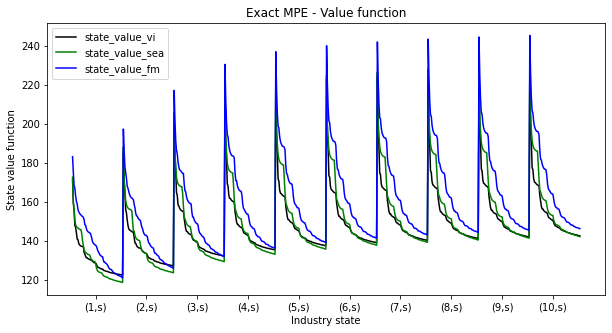

In [72]:
state_values_vi = np.array(rearr_state_value_table_vi).reshape(660,)
# state_values_gu = np.array(rearr_state_value_table_gu).reshape(660,)
state_values_sea = np.array(rearr_state_value_table_sea).reshape(660,)
state_values_fm = np.array(rearr_state_value_table_fm).reshape(660,)
plt.figure(figsize=(10,5))
plt.plot(state_values_vi, 'black')
# plt.plot(state_values_gu, 'r')
plt.plot(state_values_sea, 'green')
plt.plot(state_values_fm, 'blue')
plt.xticks(xs, labels)
plt.xlabel('Industry state')
plt.ylabel('State value function')
plt.title('Exact MPE - Value function')
plt.legend(['state_value_vi', 'state_value_sea', 'state_value_fm'])
# plt.savefig(path + 'exact MPE - value function', facecolor='w')
plt.show()

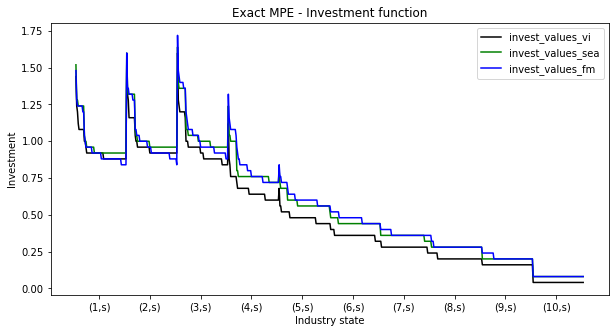

In [75]:
invest_values_vi = np.array(rearr_invest_policy_table_vi).reshape(660,)
# invest_values_gu = np.array(rearr_invest_policy_table_gu).reshape(660,)
invest_values_sea = np.array(rearr_invest_policy_table_sea).reshape(660,)
invest_values_fm = np.array(rearr_invest_policy_table_fm).reshape(660,)

plt.figure(figsize=(10,5))
plt.plot(invest_values_vi, 'black')
# plt.plot(invest_values_gu, 'r')
plt.plot(invest_values_sea, 'green')
plt.plot(invest_values_fm, 'blue')
plt.xticks(xs, labels)
plt.xlabel('Industry state')
plt.ylabel('Investment')
plt.title('Exact MPE - Investment function')
plt.legend(['invest_values_vi', 'invest_values_sea', 'invest_values_fm'])
plt.savefig(path + 'exact MPE - investment function', facecolor='w')
plt.show()